In [1]:
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem


from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

import logging

In [2]:
from lxml import etree
import os

import xml.etree.ElementTree as ET
from xml.dom import minidom

home_dir = os.path.expanduser("~")
ruta_datos = os.path.join(home_dir, "PprzGCS", "Planificacion", "datos.txt")
Estrategia = pd.read_csv(ruta_datos, delimiter=':', header = None) #Datos.txt
Estrategia=pd.DataFrame(Estrategia)

#Carga de archivo XML
Mapa = Estrategia.iloc[0,1]
Archivo = Estrategia.iloc[1,1]
Controlador = Estrategia.iloc[2,1]
Aircraft = Estrategia.iloc[3,1]

ruta_archivo = os.path.join(home_dir, "paparazzi", "conf", "flight_plans", "UCM", f"{Archivo}.xml")
tree = ET.parse(ruta_archivo)
root = tree.getroot()

# Ruta a tu archivo XML y DTD
xml_file = ruta_archivo
ruta_dtd = os.path.join(home_dir, "paparazzi", "conf", "flight_plans", "flight_plan.dtd")
dtd_file = ruta_dtd

# Expande la ruta
dtd_file = os.path.expanduser(dtd_file)

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Expande la ruta
xml_file = os.path.expanduser(xml_file)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


El archivo XML es válido.


In [3]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#Leemos los archivos sacados del boton de planificación

#Carga de archivo XML

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []
home = []
#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        #lat = float(waypoint.get('lat'))
        #lon = float(waypoint.get('lon'))
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        #print(waypoint.get('lon'))
        #print(lon)
        #print(type(lat))
        waypoint_list.append((name, x, y))
        #waypoint_list.append((name, lat, lon))
        #print("Punto", x, y)
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        #waypoint_list.append((name, lon, lat))
    if name == "HOME":
        home.append((name, x, y))
        waypoint_list.append((name, x, y))
        #print(unchanged_points)
#print("Unchanged:", unchanged_points)

sectors = {}
sectors_names = []
points_in_sectors = []
for sector in root.find('sectors'):
    sector_name = sector.attrib['name'] 
    sectors_names.append(sector_name)
    points_in_sector = sector.attrib.get('type', 'undefined')
    points_in_sectors.append(points_in_sector)
    corners = []
    for corner in sector.findall('corner'):
        corner_name = corner.attrib['name']
        #print("Corner name: ", corner_name)
        
        # Comprobar si corner_name está en unchanged_points
        for name, x, y in unchanged_points:
            if corner_name == name:
                #print("Point: ", (x, y))
                corners.append((x, y))
                break  # Salir del bucle una vez que se encuentra el punto

    sectors[sector_name] = corners

print("Sectors: ", sectors)


#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
sectors_points=[]
for sector_name, coords in sectors.items():
    for coord in coords:
        sectors_points.append((sector_name, coord[0], coord[1]))
sectors_array = np.array(sectors_points, dtype=object)
#sectors = np.array([[nombre, x, y] for nombre, x, y in sectors])
points = np.concatenate((waypoints, unchangedpoints), axis=0)
unchanged_points = np.concatenate((unchanged_points, sectors_points), axis = 0)
print("Sectors_array: ", sectors_array)
print("Waypoints: ", waypoint_list)

Sectors:  {'Net': [(796.4, 1254.9), (796.4, -865.4), (-908.7, -865.4), (-908.7, 1254.9)], 'ZigZag1': [(-655.5, 1054.3), (-384.6, 946.3), (-643.5, 863.8)]}
Sectors_array:  [['Net' 796.4 1254.9]
 ['Net' 796.4 -865.4]
 ['Net' -908.7 -865.4]
 ['Net' -908.7 1254.9]
 ['ZigZag1' -655.5 1054.3]
 ['ZigZag1' -384.6 946.3]
 ['ZigZag1' -643.5 863.8]]
Waypoints:  [('HOME', 0.0, 0.0), ('BZ0', 169.4, 939.6), ('BZ1', -532.9, 529.5), ('BZ2', -407.6, 233.0), ('BZ3', -398.7, -214.4)]


In [4]:
unchanged_points

array([['HOME', '0.0', '0.0'],
       ['STDBY', '333.9', '620.6'],
       ['ELLIPSE', '296.3', '624.4'],
       ['_N1', '796.4', '1254.9'],
       ['_N2', '796.4', '-865.4'],
       ['_N3', '-908.7', '-865.4'],
       ['_N4', '-908.7', '1254.9'],
       ['T1_1', '-655.5', '1054.3'],
       ['T1_2', '-384.6', '946.3'],
       ['T1_3', '-643.5', '863.8'],
       ['Net', '796.4', '1254.9'],
       ['Net', '796.4', '-865.4'],
       ['Net', '-908.7', '-865.4'],
       ['Net', '-908.7', '1254.9'],
       ['ZigZag1', '-655.5', '1054.3'],
       ['ZigZag1', '-384.6', '946.3'],
       ['ZigZag1', '-643.5', '863.8']], dtype='<U32')

In [5]:
#Ahora hay que calcular el centroide de cada sector y añadirlo a las paradas

def calcular_centroide(puntos):
    n = len(puntos)  # Número de vértices
    C_x = sum(x for x, y in puntos) / n  # Promedio de las coordenadas x
    C_y = sum(y for x, y in puntos) / n  # Promedio de las coordenadas y
    return C_x, C_y  # Devuelve el centroide como una tupla

#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = np.array(waypoints[:,-2:])
print("Paradas:\n", paradas)
#Definimos parámetros del barco
velocidad_media = 40

centroides = []

for i in range(len(sectors_names)):
    C_x, C_y = calcular_centroide(sectors[sectors_names[i]])
    print("Puntos del centroide:\n", sectors[sectors_names[i]])
    C_i = [C_x, C_y]
    centroides.append(C_i)
centroides = np.array(centroides)
print("Centroides:\n", centroides)
paradas=np.vstack((paradas, centroides))
print("Paradas actualizadas:\n", paradas)

Paradas:
 [['0.0' '0.0']
 ['169.4' '939.6']
 ['-532.9' '529.5']
 ['-407.6' '233.0']
 ['-398.7' '-214.4']]
Puntos del centroide:
 [(796.4, 1254.9), (796.4, -865.4), (-908.7, -865.4), (-908.7, 1254.9)]
Puntos del centroide:
 [(-655.5, 1054.3), (-384.6, 946.3), (-643.5, 863.8)]
Centroides:
 [[ -56.15  194.75]
 [-561.2   954.8 ]]
Paradas actualizadas:
 [['0.0' '0.0']
 ['169.4' '939.6']
 ['-532.9' '529.5']
 ['-407.6' '233.0']
 ['-398.7' '-214.4']
 ['-56.150000000000034' '194.75000000000006']
 ['-561.1999999999999' '954.7999999999998']]


In [6]:
class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

In [7]:
import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a TkAgg para mostrar ventanas gráficas
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.core.problem import ElementwiseProblem


class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):

        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)

        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=2,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia, tiempo]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        Max_dist=self.get_route_length(x)-100000000000
        
        Max_tiempo=self.get_route_length(x)/velocidad_media-1000000000000

        x_ord=np.sort(x)
        penalty_paradas=0
        for i in range(len(x_ord)-1):
            if x_ord[i] == x_ord[i+1]:
                penalty_paradas=10000
                
        out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist


def visualize_3(problem, x, n, sectors, fig=None, ax=None, show=True, label=True):
 with plt.style.context('ggplot'):
        x=x[0]
        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # plot cities using scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # annotate cities
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # plot the line on the path
        for i in range(len(x)-1):
            current = x[i]
            next_ = x[(i + 1)]
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        # Ploteamos los sectores
        for sector_name, points in sectors.items():
            sector_points = np.array(points)
            ax.fill(sector_points[:, 0], sector_points[:, 1], alpha=0.2, label=f'Sector {sector_name}')
         
        fig.suptitle(f"Route length: {problem.get_route_length(x)}km \nRoute time: {problem.get_route_length(x)*60/velocidad_media}min")

        if show:
            fig.show()

            X, F = res.opt.get("X", "F")
    
        from pymoo.visualization.scatter import Scatter
        
        plot = Scatter()
        plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
        plot.add(res.F, facecolor="none", edgecolor="red")
        %matplotlib inline
        plot.show()


In [8]:

def closest_point_and_reorder(home, points):

    # Convertir las coordenadas de los puntos a un numpy array y trabajar solo con las coordenadas (últimas 2 columnas)
    coords = np.array(points[:, -2:], dtype=float)
    
    # Convertir el punto fijo a un array numpy
    home = np.array(home, dtype=float)
    
    # Calcular las distancias euclidianas entre el punto fijo y cada punto de 'coords'
    distances = np.linalg.norm(coords - home, axis=1)
    
    # Encontrar el índice del punto con la menor distancia
    closest_index = np.argmin(distances)
    
    # Reordenar los puntos colocando el más cercano en la primera posición
    reordered_points = np.vstack([points[closest_index], np.delete(points, closest_index, axis=0)])
    
    return reordered_points, closest_index
        
home_coord = home[0][1:]
waypoint_list = [(x, y) for (_, x, y) in waypoint_list]
waypoint_list, closest_index = closest_point_and_reorder(home_coord, paradas)
paradas = waypoint_list
print(waypoint_list)

[['0.0' '0.0']
 ['169.4' '939.6']
 ['-532.9' '529.5']
 ['-407.6' '233.0']
 ['-398.7' '-214.4']
 ['-56.150000000000034' '194.75000000000006']
 ['-561.1999999999999' '954.7999999999998']]


In [9]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas

n_barcos = 1

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Maximum Span: [2662.673   66.567]
Function Evaluations: 1999
[[0 5 4 3 2 6 1]]


/tmp/ipykernel_31486/1287751465.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


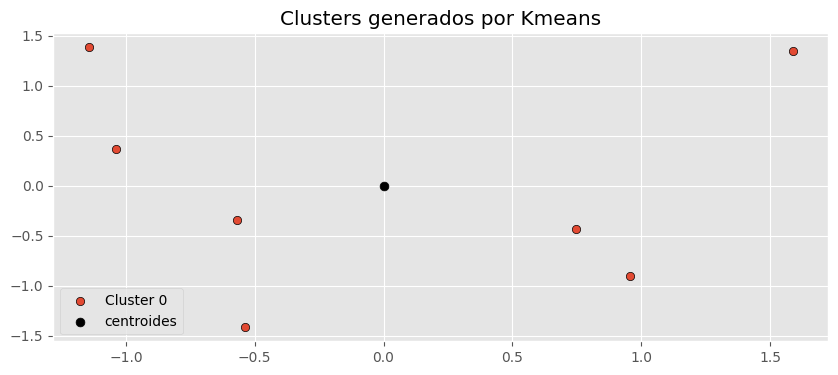

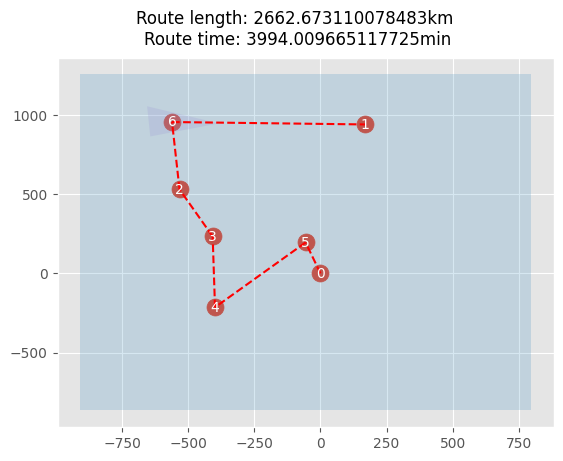

In [10]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

#Creamos un diccionario para almacenar cada ruta
rutas={}
waypoint_list = np.array(waypoint_list, dtype=object)
stops = waypoint_list.astype(float)
#print(stops)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:, 0], stops[:, 1], y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)

    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        repair=StartFromZeroRepair(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )
    
    # if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
    #termination = DefaultSingleObjectiveTermination(period=200, n_max_gen=np.inf)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos, sectors)
    


In [11]:
#res.X[0][0] = closest_index
#print(res.X)
#mascara = (res.X <= closest_index)
#mascara[0] = False
#res.X[mascara]-=1
#print(res.X)

In [12]:
#En este vector vamos a tener el orden del TSP pero con las coordenadas
resultado = []

for i in range(len(res.X[0])):

    idx = res.X[0][i]
    resultado.append(paradas[idx])

resultado = np.vstack(resultado)

In [13]:
# Crear una cuadrícula dentro del área
def generar_waypoints_area(polygon, centroide, vertices, Pnts_total, x_inicio, y_inicio, x_fin, y_fin, estrategia):

    min_x, min_y, max_x, max_y = polygon.bounds
    waypoints = []
    punto_final=(x_fin, y_fin)
    #waypoints.append((x_inicio, y_inicio))
    #print(x_inicio, y_inicio)
    print("Estrategia: ", estrategia)
    if estrategia.startswith("ZigZag"):  
        x_paso = np.abs(min_x-max_x)/(np.sqrt(Pnts_total)+1)
        y_paso = np.abs(min_y - max_y)/(np.sqrt(Pnts_total)+1)
        Pnts_total=(Pnts_total)
        #x_paso = int(Pnts_total)
        #y_paso = int(Pnts_total)
        y_vals = np.arange(min_y, max_y, y_paso)
        x_vals = np.arange(min_x, max_x, x_paso)
        print("long y_vals", len(y_vals))
        #print("long x_vals", len(x_vals))
        #print("x_vals", x_vals)
        #print("y_vals", y_vals)
        area=polygon.area
        #pasos=100
        #print("pasos: ", x_paso)
        #print("area: ", area)
        centroide_i = Point(centroide[0], centroide[1])
        #print("distancia",([centroide_i.distance(Point(v)) for v in poligono.exterior.coords]))
        #print("cuenta_mano", [centroide_i.distance(Point(v)) for v in puntos])
        # Asegurarse de que los puntos de inicio son flotantes
        #waypoints.append((float(x_inicio), float(y_inicio)))
    
        # Calcular las distancias a los vértices
        dists = []
        for i in range(len(vertices)):
            vertice = np.array(vertices[i], dtype=float)
            dist = np.linalg.norm(vertice - np.array((float(x_inicio), float(y_inicio))))
            dists.append(dist)
        
        # Obtener el punto más cercano
        min_index = np.argmin(dists)
        closest_point = tuple(map(float, vertices[min_index]))  # Asegúrate de que es una tupla de flotantes
        waypoints.append(closest_point)  # Agregar el punto más cercano
    
        punto_final = (float(x_fin), float(y_fin))
        punto_inicial=(float(x_ini),float(y_ini))
        # Controlar el orden de los puntos
        if punto_final[1] < (max_y / 2):
            y_vals = np.flip(y_vals)
        if punto_final[0] < (max_x / 2):
            x_vals = np.flip(x_vals)
    
        # Generar waypoints dentro del polígono
        for y in y_vals:
            for x in x_vals:
                point = Point(x, y)
                if polygon.contains(point):
                    waypoints.append((float(x), float(y)))  # Asegurarte de que son flotantes      
    #print("Waypoints inicio", waypoints)
    if estrategia.startswith("Espiral"):
        
        centroide_i = Point(centroide[0], centroide[1])
        #radio_maximo = max([centroide_i.distance(Point(v)) for v in poligono.exterior.coords])
        #radio_minimo = min([centroide_i.distance(Point(v)) for v in poligono.exterior.coords])
        
        mediatrices = [Point((vertices[i][0] + vertices[i+1][0]) / 2, (vertices[i][1] + vertices[i+1][1]) / 2)
        for i in range(len(vertices) - 1)]

        distancia_mediatrices = [centroide_i.distance(punto_medio) for punto_medio in mediatrices]

        radio_maximo = max(distancia_mediatrices)
        radio_minimo = min(distancia_mediatrices)
        
        print("distancias", (distancia_mediatrices))
        print("centroide", centroide_i)
        radio_inicial = radio_maximo*0.2
        

        #Añadir un warning de que si no caben los puntos introducidos por el usuario el algoritmo va a recorrer la region con menos puntos

        #OPCIÓN CON SEPARACIÓN FIJA DMIN POR VUELTA
        #D_min = 0.05 #Tamaño para que el barco pueda moverse correctamente/error de la sonda
        #vueltas_totales = (radio_minimo-radio_inicial)/D_min 
        #print("Total de puntos", Pnts_total)
        #Pnts_total = Pnts_total
        #Pnts_1vuelta = Pnts_total/vueltas_totales
        #incremento_radio = D_min/(Pnts_1vuelta)

        #OPCIÓN CON SEPARACIÓN DMIN EN LA PRIMERA VUELTA
        D_min = radio_minimo/Pnts_total #Tamaño para que el barco pueda moverse correctamente/error de la sonda
        Pnts_1vuelta = 2*np.pi*radio_inicial*0.35/D_min #Ponemos como ajuste de error el 50% del radio inicial
        vueltas_totales = Pnts_total/Pnts_1vuelta
        incremento_radio = (radio_minimo/vueltas_totales)/(Pnts_1vuelta)
        
        # Asegurarse de que los puntos de inicio son flotantes
        #waypoints.append((float(x_inicio), float(y_inicio)))
        #waypoints.insert(0,centroide)
        print("Tras el insert", waypoints)
        punto_final = (float(x_fin), float(y_fin))
        punto_inicial=(float(x_ini),float(y_ini))
        print("Pnts 1 vuelta: ", Pnts_1vuelta)
        print("vueltas totales: ", vueltas_totales)
        
        pasos = Pnts_total
        print("pasos: ", pasos)
        pasos = int(pasos)
        
        theta = np.linspace(0, 2 * vueltas_totales * np.pi, pasos)  # Genera ángulos para la espiral
        radio = np.linspace(radio_inicial, radio_inicial + incremento_radio * pasos, pasos)
        signo = 1
        
        if float(x_fin) > float(max_x/2):
            signo = -1
            
        for r, t in zip(radio, theta):
            x = centroide[0] + signo*r * np.cos(t)
            y = centroide[1] + signo*r * np.sin(t)
            punto = Point(x, y)
            #print(punto)
            if polygon.contains(punto):  # Solo añade el punto si está dentro del polígono
                #print("Cada iteracion\n", waypoints)
                waypoints.append((float(x), float(y)))
            #waypoints.reverse()  # Invertir el orden una vez al final si es necesario
    #print("Waypoints=",waypoints)
        #waypoints.insert(0, punto_inicial)

    #Ahora añadimos un punto final
    #waypoints.append(punto_final)
    #print("Despues del punto_final", waypoints)
    return waypoints

ZigZag1
Indice =  6
Sector indice =  5
punto_inicial 2
punto_final 6
Estrategia:  ZigZag1
long y_vals 4
Puntos en el poligono =  7


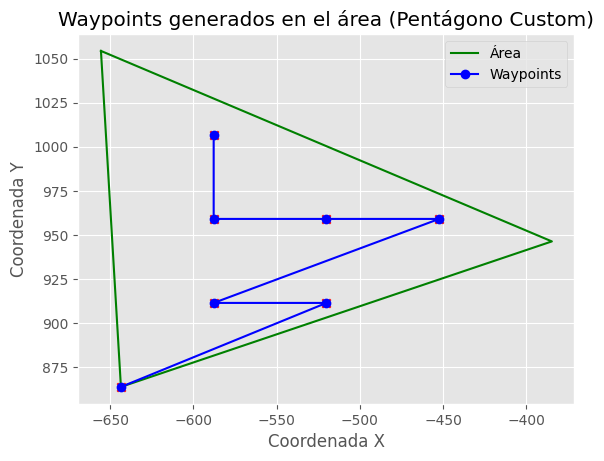

In [14]:
# Importar bibliotecas necesarias
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
import math
    
long_añadidos = 0
resultados_sectores = [list(map(float, punto)) for punto in resultado]
# Suponiendo que tienes un bucle que llama a esta función con los parámetros adecuados
for i in range(len(sectors_names)):
    if sectors_names[i] != 'Net':
        print(sectors_names[i])
        poligono = Polygon(sectors[sectors_names[i]])
        vertices = sectors[sectors_names[i]]
        area = poligono.area
        
        Estrategia_recorrido=sectors_names[i]
        n_puntos=int(points_in_sectors[i])
    
        vertices = sectors[sectors_names[i]]
        # Obtener coordenadas iniciales y finales
        print("Indice = ", len(paradas) - len(sectors) + i)
        sector_indice = (np.where(res.X == len(paradas) - len(sectors) + i)[1])[0]
        print("Sector indice = ",sector_indice)
        punto_inicial = res.X[0][sector_indice - 1]
        print("punto_inicial", punto_inicial)
        if sector_indice < len(res.X)-1:
            punto_final = res.X[0][sector_indice + 1]
        else:
            punto_final = res.X[0][sector_indice]
        print("punto_final", punto_final)
        x_ini = paradas[punto_inicial, 0]
        y_ini = paradas[punto_inicial, 1]
        x_fin = paradas[punto_final, 0]
        y_fin = paradas[punto_final, 1]
        
        waypoints = generar_waypoints_area(poligono, centroides[i], vertices, n_puntos, x_ini, y_ini, x_fin, y_fin, Estrategia_recorrido)
        #print("Waypoints = ", waypoints)
        #print("Long wp", len(waypoints))
        #print("Long res ini", len(resultados_sectores
        if Estrategia_recorrido.startswith("ZigZag"):
            
            resultados_sectores = np.delete(resultados_sectores, sector_indice + long_añadidos, axis = 0)
            #Punto_borrado=resultados_sectores[sector_indice + long_añadidos]
            #print("Punto borrado=", Punto_borrado)
            resultados_sectores = np.insert(resultados_sectores, sector_indice + long_añadidos, waypoints, axis = 0)
            #print("Puntos añadidos=", waypoints)
            #print("Resultado sectores=", resultados_sectores)
        elif Estrategia_recorrido.startswith("Espiral"):
            resultados_sectores = np.delete(resultados_sectores, sector_indice + long_añadidos, axis = 0)
            resultados_sectores = np.insert(resultados_sectores, sector_indice + long_añadidos, waypoints, axis = 0)

        long_añadidos+=len(waypoints)-1
       # Dibujar el área y los waypoints
        x_coords, y_coords = zip(*waypoints)
    
        print("Puntos en el poligono = ", len(x_coords))
        
        # Dibujar el pentágono
        x_poly, y_poly = poligono.exterior.xy
        plt.plot(x_poly, y_poly, color='green', label='Área')
        
        # Dibujar el recorrido (waypoints)
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Waypoints')
        plt.scatter(x_coords, y_coords, marker='x', color='red')  # Marcar los puntos
        #plt.scatter(centroides[0], centroides[1], s=250, marker='o', color='orange') #Marcar el centroide
        plt.title('Waypoints generados en el área (Pentágono Custom)')
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.grid(True)
        plt.legend()
        plt.show()


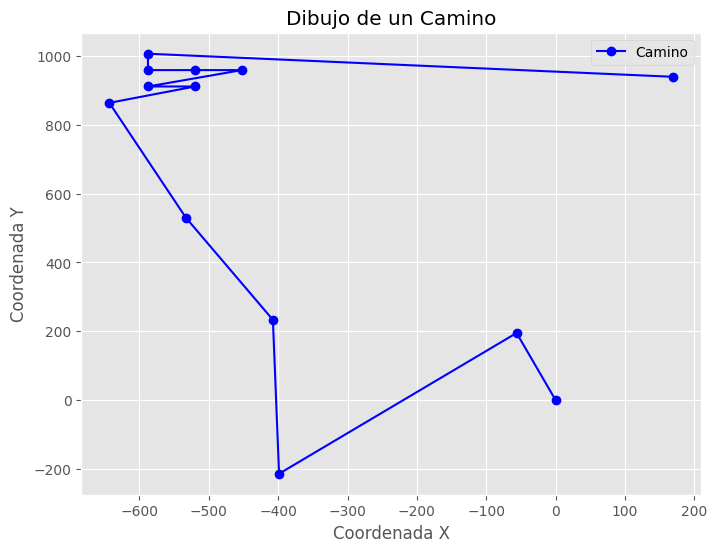

In [15]:
3# Crear el gráfico
plt.figure(figsize=(8, 6))

# Dibujar el camino
plt.plot(resultados_sectores[:,0], resultados_sectores[:,1], marker='o', linestyle='-', color='b', label='Camino')

# Agregar etiquetas y título
plt.title('Dibujo de un Camino')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()


In [16]:
# Ahora hay que meter estos puntos en el xml

# Añadimos una columna de ceros donde meteremos los nombres
Columna_nombres = np.zeros(resultados_sectores.shape[0], dtype=object)  # Cambiado a un vector de tamaño adecuado

dtype = [('nombre', 'U10'), ('x', 'f4'), ('y', 'f4')]  # U10 para string, f4 para float

# Concatenar la columna de nombres y Puntos_Bezier
ruta = np.empty(len(Columna_nombres), dtype=dtype)  # Crear un array vacío del tipo correcto
ruta['nombre'] = Columna_nombres  # Asignar la columna de nombres
ruta['x'] = resultados_sectores[:, 0]  # Asignar la columna x
ruta['y'] = resultados_sectores[:, 1]  # Asignar la columna y

unchanged_array = np.zeros(len(unchangedpoints), dtype=dtype)

# Ponemos el nombre en la columna correspondiente
resultados_sectores = resultados_sectores[1:] #Como se ha añadido el home en el TSP como el primer punto, ahora hay que quitarlo
for i in range(len(resultados_sectores)):
    if ruta[i]['x'] == home_coord[0] and ruta[i]['y'] == home_coord[1]:
        ruta[i]['nombre'] = 'Home'
    else:
        ruta[i]['nombre']=f'L{i}'
#print(resultado)
vertices_xy = np.empty(len(sectors_array), dtype=dtype)
for i, (nombre, x, y) in enumerate(sectors_array):
    vertices_xy[i]['x'] = x
    vertices_xy[i]['y'] = y
    vertices_xy[i]['nombre'] = nombre

# Rellenamos este array
for i, (nombre, x_str, y_str) in enumerate(unchangedpoints):
    #print("x: ", x_str)
    #print("y: ", y_str)
    #print("Nombre: ", nombre)
    unchanged_array[i] = (nombre, float(x_str), float(y_str)) 

#Si se añade para que vaya más de un barco esto habrá que modificarlo para que cree diferentes archivos
# Reescribir todos los waypoints organizados desde 'resultados'

for name, x, y in ruta:
    new_waypoint = ET.Element('waypoint', x=str(x), y=str(y), name=name)
    way_points.append(new_waypoint)
for name, x, y in unchangedpoints:
    new_unchanged = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_unchanged)
#Ahora hay que borrar la sección type de sectors ya que paparazzi no la interpreta pero nos ha valido para la optimizacion
for sector in root.findall(".//sector"):
    if 'type' in sector.attrib:
        del sector.attrib['type']


In [17]:
sectors_array

array([['Net', 796.4, 1254.9],
       ['Net', 796.4, -865.4],
       ['Net', -908.7, -865.4],
       ['Net', -908.7, 1254.9],
       ['ZigZag1', -655.5, 1054.3],
       ['ZigZag1', -384.6, 946.3],
       ['ZigZag1', -643.5, 863.8]], dtype=object)

In [18]:
# Ruta al archivo de texto donde se guardarán los puntos
from pyproj import CRS, Transformer

crs_wgs84 = CRS.from_epsg(4326)  # WGS84 (lat, lon)
crs_utm = CRS.from_epsg(32633)   # UTM zona 33N
transformer = Transformer.from_crs(crs_wgs84, crs_utm)

# Función para guardar los puntos en un archivo .txt
def guardar_puntos_en_txt(puntos, archivo_salida):
    try:
        with open(archivo_salida, 'w') as f:
            # Escribir los encabezados
            f.write("Nombre\tlat\tlon\n")
            
            # Escribir los puntos
            for punto in puntos:
                lat, lon = transformer.transform(punto['x'], punto['y'], direction='INVERSE')
                f.write(f"{punto['nombre']}\t{lat}\t{lon}\n")
        
        print(f"Los puntos han sido guardados exitosamente en '{archivo_salida}'")
    
    except Exception as e:
        print(f"Error al guardar los puntos: {e}")

# Llamamos a la función para guardar los puntos en el archivo de texto
ruta_waypoints_finales = os.path.join(home_dir, "PprzGCS", "Planificacion", "Resources", "waypoints.txt")
guardar_puntos_en_txt(ruta, ruta_waypoints_finales)

#También guardaremos los vértices de los sectores
ruta_sectores_finales = os.path.join(home_dir, "PprzGCS", "Planificacion", "Resources", "sectores.txt")
guardar_puntos_en_txt(vertices_xy, ruta_sectores_finales)

Los puntos han sido guardados exitosamente en '/home/dacya-iagesbloom/PprzGCS/Planificacion/Resources/waypoints.txt'
Los puntos han sido guardados exitosamente en '/home/dacya-iagesbloom/PprzGCS/Planificacion/Resources/sectores.txt'


In [19]:
# Ahora hay que meter estos puntos en el xml

# Añadimos una columna de ceros donde meteremos los nombres
Columna_nombres = np.zeros(resultados_sectores.shape[0], dtype=object)  # Cambiado a un vector de tamaño adecuado

dtype = [('nombre', 'U10'), ('x', 'f4'), ('y', 'f4')]  # U10 para string, f4 para float

# Concatenar la columna de nombres y Puntos_Bezier
ruta = np.empty(len(Columna_nombres), dtype=dtype)  # Crear un array vacío del tipo correcto
ruta['nombre'] = Columna_nombres  # Asignar la columna de nombres
ruta['x'] = resultados_sectores[:, 0]  # Asignar la columna x
ruta['y'] = resultados_sectores[:, 1]  # Asignar la columna y

unchanged_array = np.zeros(len(unchangedpoints), dtype=dtype)

# Ponemos el nombre en la columna correspondiente
resultados_sectores = resultados_sectores[1:] #Como se ha añadido el home en el TSP como el primer punto, ahora hay que quitarlo
for i in range(len(resultados_sectores)):
        ruta[i]['nombre']=f'L{i}'
#print(resultado)

# Rellenamos este array
for i, (nombre, x_str, y_str) in enumerate(unchangedpoints):
    #print("x: ", x_str)
    #print("y: ", y_str)
    #print("Nombre: ", nombre)
    unchanged_array[i] = (nombre, float(x_str), float(y_str)) 

#Si se añade para que vaya más de un barco esto habrá que modificarlo para que cree diferentes archivos
# Reescribir todos los waypoints organizados desde 'resultados'

for name, x, y in ruta:
    new_waypoint = ET.Element('waypoint', x=str(x), y=str(y), name=name)
    way_points.append(new_waypoint)
for name, x, y in unchangedpoints:
    new_unchanged = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_unchanged)
#Ahora hay que borrar la sección type de sectors ya que paparazzi no la interpreta pero nos ha valido para la optimizacion
for sector in root.findall(".//sector"):
    if 'type' in sector.attrib:
        del sector.attrib['type']
        
# Función para formatear el XML
def prettify(element):
    """ Devuelve una versión 'bonita' del XML """
    rough_string = ET.tostring(element, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

# Guardar los cambios en el archivo XML
ruta_archivo_opt = os.path.join(home_dir, "paparazzi", "conf", "flight_plans", "UCM", f"{Archivo}_opt.xml")
with open(ruta_archivo_opt, 'w', encoding='utf-8') as f:
    print("Archivo actualizado")
    f.write('<!DOCTYPE flight_plan SYSTEM "../flight_plan.dtd">\n')
    f.write(prettify(root))
#print("FLIGHT PLAN GUARDADO")
# print("Waypoints reescritos y guardados")
    
import xml.etree.ElementTree as ET

# Abrimos el archivo XML
ruta_controlador = os.path.join(home_dir, "paparazzi", "conf", "airframes", "UCM", f"{Controlador}.xml")
tree = ET.parse(ruta_controlador)
root = tree.getroot()

n_segmentos = str(len(paradas) - 1)  # Asegúrate de que `paradas` esté definida en el código

# Bandera para verificar si el cambio se realizó
cambio_realizado = False

# Buscar y modificar el valor de `GVF_PARAMETRIC_BARE_2D_BEZIER_N_SEG`
for module in root.iter('module'):
    if module.get('name') == 'gvf_parametric_bare':
        for define in module.findall('define'):
            if define.get('name') == 'GVF_PARAMETRIC_BARE_2D_BEZIER_N_SEG':
                define.set('value', n_segmentos)
               # print("Nuevo valor asignado a GVF_PARAMETRIC_BARE_2D_BEZIER_N_SEG:", define.get('value'))
                cambio_realizado = True  # Marcar el cambio como realizado

if not cambio_realizado:
   print("No se encontró el módulo o define especificado.")

#Ahora vamos a modificar el archivo conf.xml que se encuentra en la ruta paparazzi/conf/airframes/UCM para que cuando se abra paparazzi de nuevo el flight plan y el airframe sean los que pongamos aqui

# Ruta del archivo XML que deseas modificar
ruta_conf = os.path.join(home_dir, "paparazzi", "conf", "airframes", "UCM", "conf.xml")
tree = ET.parse(ruta_conf)
root = tree.getroot()

new_flight_plan = f'flight_plans/UCM/{Archivo}_opt.xml'
new_airframe = f'airframes/UCM/{Controlador}.xml'
aircraft_name = Aircraft
# Parsear el archivo XML

#Buscar el nodo correspondiente al aircraft
for aircraft in root.iter('aircraft'):
    # Si el nombre del aircraft coincide, actualizar los valores
    if aircraft.get('name') == aircraft_name:
        aircraft.set('airframe', new_airframe)
        aircraft.set('flight_plan', new_flight_plan)
# Guardar los cambios en el archivo XML
output_path_comp = ruta_conf
tree.write(output_path_comp, encoding='utf-8', xml_declaration=True)
#f.write(prettify(root))

Archivo actualizado
